# COSE461 Assignment 1: Word Vectors
### **Due 5:00 PM, Thu Sep 16**

Welcome to COSE461. If you face any problem (e.g. submission script not working), ask me through Blackboard.

## About using Colab
Our assignment will be in the form of Jupyter notebooks to be able to be run in Google Colab. Colab is an online editor that provides free access to a GPU, so you don't have to worry about the computing resources when doing the assignements. GPU can be accessed by `Edit->Notebook settings` or `수정->노트 설정` and choosing GPU in the Hardware accelerator dropdown (We will not be using a GPU in the current assignment, though). To get started, make a copy of the assignment by clicking `File->Save a copy in drive...` or `파일->드라이브에 사본 저장`.  You will need to be logged into a Google account, such as your @korea.ac.kr mail account.
 
 The code cells in Colab are executed on a `preemtible` VM instance. This means:
 - Every time you open the notebook, you will be assigned a different machine; run cells and files will be lost.
 - Even if you keep using a machine attached to notebook, it can be lost and altered with other machine after 24 hours.

Therefore, if you have some output that you don't want to lose, you should download them to your local machine or save them to your Google drive by mounting it to the VM instance. The former can be done by `File->Download` or `파일->다운로드`, where the latter can be done by using something similar to the following code snippet:



```
from google.colab import drive

# mount Google drive
drive.mount('/mnt/')

# You can run a linux command by putting ! at the start
# The following commands shows the number of files in your drive
!echo -e "\n# of files in /mnt/My Drive/:"
!ls -l "/mnt/My Drive/" | wc -l

```

One important limitation to Colab is that it disconnects from VM when is inactive for a few tens of minutes. So you should either check Colab periodically, or use something like [this](https://stackoverflow.com/questions/54057011/google-colab-session-timeout). If you have available computing resources and if you do not want to go through such inconvenience, feel free to use yours by recreating a similar environment to Colab.

---



# Word vectors
This assignment is based on the Stanford CS224n lecture by Christopher Manning. The followings are the import, data downloading, and unzipping statements. Do not modify, and simply run it once before going down.

In [2]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

np.random.seed(0)
random.seed(0)
!unzip -nq /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

[nltk_data] Downloading package reuters to /root/nltk_data...


Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from co-occurrence matrices, and those derived via GloVe.

**Note on Terminology**: The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As Wikipedia states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

# Part 1: Count-based word vectors
#### You Shall know a word by the company it keeps (Firth, J. R. 1957:11)
Many word vector implementations are driven by the idea that **similar words**, i.e., (near) synonyms, **will be used in similar contexts**. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

## Co-occurence
A co-occurrence matrix counts how often things co-occur in some environment. Given some word  $w_i$  occurring in the document, we consider the context window surrounding  $w_i$ . Supposing our fixed window size is  $n$ , then this is the  $n$  preceding and  $n$  subsequent words in that document, i.e. words  $w_{i−n}…w_{i−1}$  and  $w_{i+1}…w_{i+n}$ . We build a co-occurrence matrix  $M$ , which is a symmetric word-by-word matrix in which  $M_{ij}$  is the number of times  $w_j$  appears inside  $w_i$ 's window among all documents.

**Example: Co-occurence with fixed window of $n=1$**

Document 1: *all that glitters is not gold*

Document 2: *all is well that ends well*


| *   |	`<START>`	| all	| that | glitters	| is	| not	| gold	| well	| ends	|`<END>`|
| --- | ---     | --- | ---  | ---      | --- | --- | ---   | ---   | ---   | --- |
|`<START>`	|0|	2|	0|	0|	0|	0|	0|	0|	0|	0| |
|all	|2	|0	|1	|0	|1	|0	|0	|0	|0	|0 |
|that	|0	|1	|0	|1	|0	|0	|0	|1	|1	|0 |
|glitters	|0	|0	|1	|0	|1	|0	|0	|0	|0	|0|
|is	|0	|1	|0	|1	|0	|1	|0	|1	|0	|0|
|not|	0|	0|	0|	0|	1|	0|	1|	0|	0|	0|
|gold|	0|	0|	0|	0|	0|	1|	0|	0|	0|	1|
|well|	0|	0|	1|	0|	1|	0|	0|	0|	1|	1|
|ends	|0	|0	|1	|0	|0	|0	|0	|1	|0	|0|
|`<END>`	|0	|0	|0	|0	|0	|0	|1	|1	|0	|0|

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run dimensionality reduction. In particular, we will run SVD (Singular Value Decomposition), which is a kind of generalized PCA (Principal Components Analysis) to select the top  $k$  principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is  $A$  with  $n$  rows corresponding to  $n$  words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal  $S$  matrix, and our new, shorter length- $k$  word vectors in  $U_k$.

<div align="center">

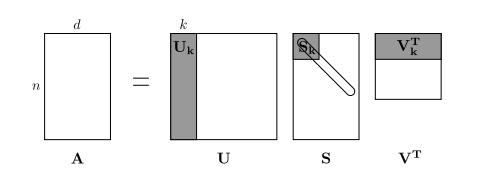

</div>


This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*.

**If you are not friendly to SVD:** you can refer to [this comprehensive tutorial](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf) or these lecture notes ([1](https://web.stanford.edu/class/cs168/l/l7.pdf), [2](http://theory.stanford.edu/~tim/s15/l/l8.pdf), [3](https://web.stanford.edu/class/cs168/l/l9.pdf) ) of Stanford CS168. While these materials give a great introduction to PCA/SVD, you do not have to understand all of these materials for this assignment or this class.

##Plotting Co-Occurrence Word Embeddings
Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell above, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see [this](https://www.nltk.org/book/ch02.html). We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do not have to perform any other kind of pre-processing.

In [3]:
START_TOKEN = '<START>'
END_TOKEN = '<END>'

def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

Let's have a look what these documents are like....

In [4]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

## Question 1.1: Implement `distinct_words` [code] (2 points)


Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with for loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned corpus_words should be sorted. You can use python's sorted function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [5]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    # corpus_words = [i for i in corpus if i not in corpus]
    corpus_words = sorted([i for i in {i for j in corpus for i in j}])
    num_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, num_corpus_words

Run below for sanity check - note that this is not an exhaustive check for correctness.

In [6]:
# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)


--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


## Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)
Write a method that constructs a co-occurrence matrix for a certain window-size  $n$  (with a default of 4), considering words  $n$  before and  $n$  after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this [Stanford cs231n Python NumPy tutorial](https://cs231n.github.io/python-numpy-tutorial/).

In [7]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}
    # ------------------
    # Write your implementation here.

    M = np.zeros((num_words, num_words)) #initialize items in M as 0 with the shape of (num_words, num_words)
    for k in words:
      word2ind[k] = words.index(k) #traverse all distince words and set the index of column/row as their ordered index
    
    for i in corpus: #every sentences in the corpus
      for idx in range(len(i)): #traverse the word index in the sentence 
        for j in i[max(0, idx - window_size): idx + window_size+1]: #slide with the window of (index - window_size : index + window_size +1 ) 

            M[word2ind[i[idx]]][word2ind[j]] += 1 #add 1 to the M with each pair appearances
        M[word2ind[i[idx]]][word2ind[i[idx]]] -=1  #delete the duplicate pair of the word with itself in the window 
            
    return M, word2ind

Run below for sanity check - note that this is not an exhaustive check for correctness.

In [8]:
print(distinct_words(test_corpus)[0])
# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
print(test_corpus)
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))
# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

['<END>', '<START>', 'All', "All's", 'ends', 'glitters', 'gold', "isn't", 'that', 'well']
[['<START>', 'All', 'that', 'glitters', "isn't", 'gold', '<END>'], ['<START>', "All's", 'well', 'that', 'ends', 'well', '<END>']]
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


## Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

**Note:** Please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) for SVD. While there are numbers of implementation of SVD (e.g. numpy, scipy, ...), it is challenging to apply full SVD to large corpora due to its high asymptotic complexity. Here we only need top $k$ vector components for relative small $k$, which is the case called Truncated SVD, and some iterative algorithms for this scale reasonably. The above implementation by sklean is an efficient randomized algorithm for calculating large-scale Truncated SVD.

In [9]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    # TruncatedSVD example
    # svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
    svd = TruncatedSVD(n_components = k, n_iter = n_iters)
    svd.fit(M)
    M_reduced = svd.transform(M)
    # ------------------

    print("Done.")
    return M_reduced

Run below for sanity check - note that the code below only check shapes.

In [10]:
# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)


Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


## Question 1.4: Implement `plot_embeddings` [code] (1 point)
Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at the [Matplotlib gallery](https://matplotlib.org/stable/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [11]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    # Adapted code
    # for i,type in enumerate(types):
    # x = x_coords[i]
    # y = y_cords[i]
    # plt.scatter(x, y, marker='x', color='red')
    # plt.text(x+0.3, y+0.3, type, fontsize=9)
    # plt.show()


    for i, word in enumerate(words):
      
      # print(M_reduced[i,0],M_reduced[i,1])
      x = M_reduced[i,0]
      y = M_reduced[i,1]
      plt.scatter(x, y ,marker = "x", color = "red")
      plt.text(x, y, word, fontsize = 9)

    plt.show()



    # ------------------

Run below for sanity check - the plot produced should look like the "test solution plot" depicted below.


--------------------------------------------------------------------------------
Outputted Plot:


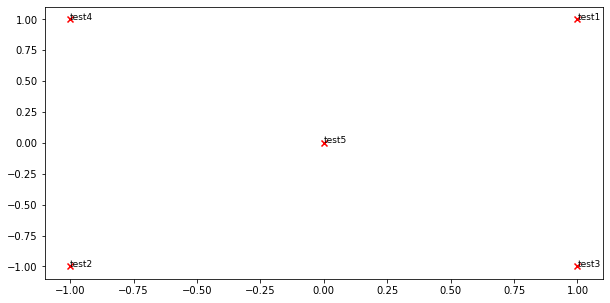

--------------------------------------------------------------------------------


In [12]:
print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

**Test Plot Solution**

<div align="center">

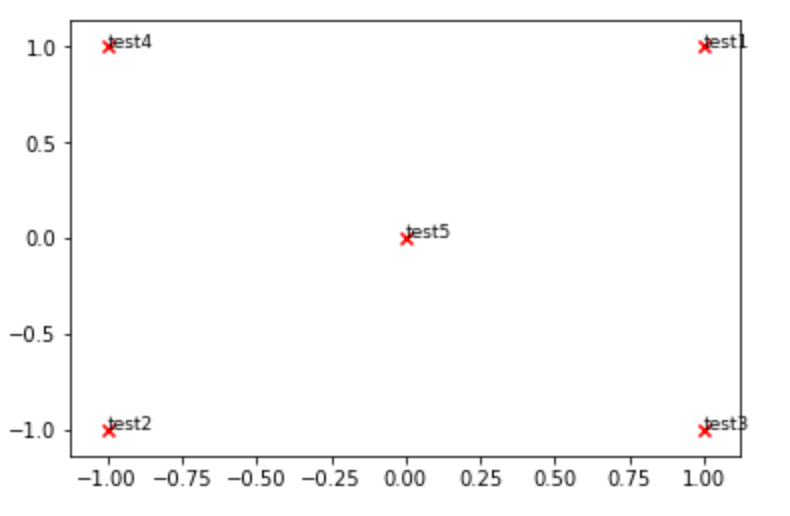
</div>

## Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use `TruncatedSVD` to compute 2-dimensional embeddings of each word. `TruncatedSVD` returns $US$, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness).

**Note:** The line of code below that does the normalizing uses the NumPy concept of broadcasting. If you don't know about broadcasting, check out [Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


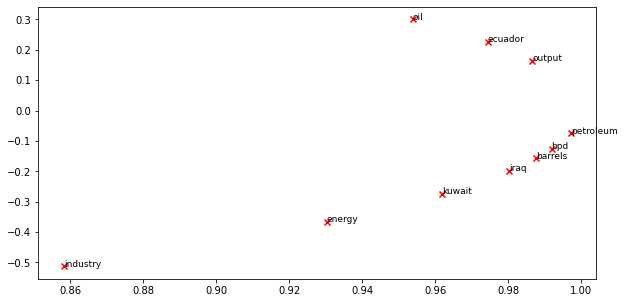

In [13]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_normalized, word2ind_co_occurrence, words)



---


**Write your answer here. You can write in either Korean or English.**


---
**1)What clusters together in 2-dimensional embedding space?** 

->

(petroleum, bpd, barrels, iraq), (oil, ecuador, output) as clusters


**2)What doesn't cluster together that you might think should have?**

->

industr should be in the cluster that contains bpd, barrels, iraq

ecuador, iraq, kuwait should've cluster together since they are countries that have oil.

oil should've cluster with bpd, barrels, petroleum.

# Part 2: Prediction-Based Word Vectors (15 points)
As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note:** If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [14]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000


**Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download.**

## Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead. Run the following cells to:

1.   Put 10000 Glove vectors into a matrix $M$
2.   Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [15]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

Run the cell below to reduce 200-dimensional word embeddings to $k$ dimensions. This should be quick to run.

In [16]:
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


## Question 2.1: GloVe Plot Analysis [written] (3 points)
Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible cause for the difference?

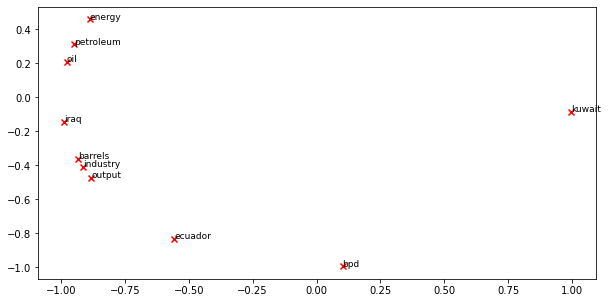

In [17]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)



---


**Write your answer here. You can write in either Korean or English.**


---
**1)What clusters together in 2-dimensional embedding space?**

-> 
As clusters:

(energy, petroleum, oil), (barrels, industry, output)



**2)What doesn't cluster together that you think should have?**

->
bpd (barrel per day) should've clustered with barrels, industry.

kuwait and ecuador should've clustered with iraq since they are both country that have oil resources



**3)How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible cause for the difference?**

->
The scale of two plots are different. The scale of the co-occurance plot is much smaller than the GloVe plot. 

The reason might've be The Co-occurance embedding use the global probability of words in the corpus, whereas the GloVe embebbing use the combination of local and global probabilities, thus more hyperparameters.





### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of $n$-dimensional vectors as points in $n$-dimensional space. If we take this perspective [$L^1$](https://mathworld.wolfram.com/L1-Norm.html) and [$L^2$](https://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:


<div align="center">

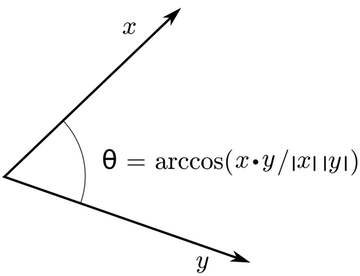

</div>

Instead of computing the actual angle, we can leave the similarity in terms of  similarity$=\cos(\theta)$. Formally, [the Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity)  $s$  between two vectors  $p$ and  $q$  is defined as:

$$s=\frac{p\cdot q}{\lVert p \rVert\lVert q \rVert},$$ where $s\in [-1, 1]$.

## Question 2.2: Words with Multiple Meanings [code + written] (1.5 points)
Polysemes and homonyms are words that have more than one meaning (see [this wiki](https://en.wikipedia.org/wiki/Polysemy) for details). Find a word with **at least two different meanings** such that the top-10 most similar words (according to cosine similarity) contain related words from **both** meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one.

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain one of the meanings of the words)?

Note: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check [the GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar).

In [18]:
print('10 Similar words to "leaves":', wv_from_bin.most_similar('leaves'))
# ------------------
# Write your implementation here.
print()
wv_from_bin.most_similar("brush")
# wv_from_bin.most_similar("realize")

# ------------------

10 Similar words to "leaves": [('ends', 0.6128067970275879), ('leaf', 0.6027014851570129), ('stems', 0.5998532176017761), ('takes', 0.5902854800224304), ('leaving', 0.5761634111404419), ('grows', 0.5663397312164307), ('flowers', 0.5600922107696533), ('turns', 0.5536050796508789), ('leave', 0.5496848821640015), ('goes', 0.5434924960136414)]



[('brushes', 0.6014487743377686),
 ('scrub', 0.575691819190979),
 ('dry', 0.5379971265792847),
 ('spray', 0.5207492709159851),
 ('paint', 0.505386471748352),
 ('thick', 0.4937582015991211),
 ('brushing', 0.487062007188797),
 ('bristle', 0.4823950231075287),
 ('wellman', 0.4770694375038147),
 ('pencil', 0.4769899845123291)]



---


**Write your answer here. You can write in either Korean or English.**


---

**1)Please state the word you discover and the multiple meanings that occur in the top 10.** 

The word "brush":

1. an action of painting
2. a type of tool, similar to "bristle" or "pencil"


**2)Why do you think many of the polysemous or homonymic words you tried didn't work?**

The reason why many of the polusemous failed to give multiple meaning is because either:

1. there are multiple spelling of the same word, and the co-occurance of these words are fairly similar.

2. same meaning with different spellings dominates the top 10.

For example the word "realize" has the meaning of 

1.achieve the goal 2. understanding something

but the top 10 words are occupied by word "realise" and the duplicate meaning from those two. 



## Question 2.3: Synonyms & Antonyms [code + written] (2 points)

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply $1 - \text{Cosine Similarity}$.

Find three words  $(w_1,w_2,w_3)$  where  $w_1$  and  $w_2$  are synonyms and  $w_1$  and  $w_3$  are antonyms, but Cosine Distance  $(w_1,w_3)<  \text{Cosine Distance}  (w_1,w_2)$ .

As an example,  $w_1 =``\text{happy}"$ is closer to  $w_3 =``\text{sad}"$ than to  $w_2 =``\text{cheerful}"$. Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see [the GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance) for further assistance.


In [26]:
print('Cosine distance between "happy" and "sad":', wv_from_bin.distance('happy', 'sad'))
print('Cosine distance between "happy" and "cheerful":', wv_from_bin.distance('happy', 'cheerful'))
# ------------------
# Write your implementation here.
print()
print('Cosine distance between "win" and "lose":', wv_from_bin.distance("win","lose"))
print('Cosine distance between "win" and "success":',wv_from_bin.distance("win","success"))


# ------------------

Cosine distance between "happy" and "sad": 0.4040136933326721
Cosine distance between "happy" and "cheerful": 0.5172466933727264

Cosine distance between "win" and "lose": 0.3553304672241211
Cosine distance between "win" and "success": 0.41681742668151855




---


**Write your answer here. You can write in either Korean or English.**


---

w1 = "win", w2 = "lose", w3 = "success"

The possible reason behind this is that the ratio of the co-occurance possibility for the word "win" and the word "lose" is higher than the one for words "win" and "success". 
So even though "success" and "win" are more close in the sense of meaning, but the occurrence of words "win" and "lose" is higher.

## Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies.

As an example, for the analogy "man : king :: woman : $x$" (read: man is to king as woman is to $x$), what is $x$?

In the cell below, we show you how to use word vectors to find $x$ using the `most_similar` function from the [GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar). The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://aclanthology.org/N18-2039.pdf) for more details). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [20]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978678703308105),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998854637146),
 ('elizabeth', 0.546359658241272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164472460746765)]


Let  $m$ ,  $k$ ,  $w$ , and  $x$  denote the word vectors for `man`, `king`, `woman`, and the answer, respectively. Using only vectors  $m$ ,  $k$ ,  $w$ , and the vector arithmetic operators  $+$  and  $−$  in your answer, what is the expression in which we are maximizing cosine similarity with  $x$ ?

**Hint:** Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `king` and the answer?



---


**Write your answer here. You can use \$ \$ signs around the letter to write mathematical symbols and equations.**


---
**what is the expression in which we are maximizing cosine similarity with  x  ?**

->

It turns out the closer the vectors by angle, the higher the cosine similarity is.
So to maximize the cosine similarity, the formula is:

$\frac{(k-m+w)\cdot x}{\left \|k-m+w\right \|\cdot \left \|x \right \|}$

<!-- $ ||k||||k-m+w||$ -->
Then the expression we maximizing cosine similarity with x is :  
$ k - m + w$
<!-- $\frac{k\cdot (k-m+w)}{\left \| k \right \|\cdot \left \|k-m+w \right \|}$ -->

<!-- $\frac{(k-m+w)\cdot x}{\left \|(k-m+w)\right \|\cdot \left \|x \right \|}$ -->


## Question 2.5: Finding Analogies [code + written] (1.5 points)
Similar to the example in the cell above in question 2.4, find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form "$x:y :: a:b$". If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note:** You may have to try many analogies to find one that works!

In [21]:
# ------------------
# Write your implementation here.
wv_from_bin.most_similar(positive=['cook', 'driver'], negative=['drive'])

# ------------------

[('chef', 0.4696432948112488),
 ('fry', 0.4497474431991577),
 ('cooking', 0.4220343232154846),
 ('cooks', 0.4195864200592041),
 ('cooked', 0.4155173599720001),
 ('baker', 0.4045046269893646),
 ('seasoned', 0.39054691791534424),
 ('tracy', 0.3904128670692444),
 ('curry', 0.3868532180786133),
 ('gordon', 0.3809589743614197)]



---


**Write your answer here. You can write in either Korean or English.**


---

drive : driver :: cook : chef

## Question 2.6: Incorrect Analogy [code + written] (1.5 points)
Find an example of analogy that does not hold according to these vectors. In your solution, state the intended analogy in the form "$x:y :: a:b$", and state the (incorrect) value of $b$ according to the word vectors.

In [22]:
# ------------------
# Write your implementation here.
wv_from_bin.most_similar(positive=['paint', 'driver'], negative=['drive'])


# ------------------

[('paints', 0.5411399602890015),
 ('painted', 0.515060544013977),
 ('painting', 0.44790053367614746),
 ('lead-based', 0.4275180995464325),
 ('drivers', 0.4243769347667694),
 ('varnish', 0.4230077266693115),
 ('sprayed', 0.4065876007080078),
 ('acrylic', 0.40325456857681274),
 ('smeared', 0.3985838294029236),
 ('painter', 0.3975690007209778)]



---


**Write your answer here. You can write in either Korean or English.**


---

drive : driver :: paint : paints

the word "paints" is not the corret word, rather it should've been "painter" in this context



## Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)
It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [23]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.6068919897079468),
 ('nurse', 0.5837947726249695),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321309566497803),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741914749146),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]

[('workers', 0.6113258004188538),
 ('employee', 0.5983108282089233),
 ('working', 0.5615328550338745),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.5368517637252808),
 ('job', 0.5278826951980591),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.505452036857605),
 ('factory', 0.4940453767776489)]




---


**Write your answer here. You can write in either Korean or English.**


---
it is biased in the sense that compared to man, 
woman are more related to the characters in the society and in the family rather than in the work space.
On the other hand, man are more related to the work rather than the social character.


## Question 2.8: Independent Analysis of Bias in Word Vectors [code + written] (1 point)
Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [24]:
# ------------------
# Write your implementation here.
wv_from_bin.most_similar(positive=['whites', 'law'], negative=['blacks']),wv_from_bin.most_similar(positive=['blacks', 'law'], negative=['whites'])

# ------------------

([('laws', 0.7078981399536133),
  ('legal', 0.5668284893035889),
  ('apply', 0.5494199991226196),
  ('rules', 0.5454568266868591),
  ('statute', 0.5447284579277039),
  ('legislation', 0.5369349718093872),
  ('act', 0.5367740392684937),
  ('constitutional', 0.5274211764335632),
  ('regulations', 0.5265931487083435),
  ('violate', 0.5262815952301025)],
 [('laws', 0.739282488822937),
  ('legal', 0.648714005947113),
  ('legislation', 0.6216896772384644),
  ('constitutional', 0.5992612838745117),
  ('rules', 0.5793452262878418),
  ('bill', 0.564017653465271),
  ('enforcement', 0.5595711469650269),
  ('criminal', 0.5518472194671631),
  ('passed', 0.5458683371543884),
  ('amendment', 0.5446867942810059)])



---


**Write your answer here. You can write in either Korean or English.**


---

with the word "whites" "blacks" "law". There is the bias that was based on the discrimination towards black people. 

Biased or racist people tend to think that the criminal is black or black people are criminals.



## Question 2.9: Thinking About Bias [written] (2 points)
Give one explanation of how bias gets into the word vectors. What is an experiment that you could do to test for or to measure this source of bias?



---


**Write your answer here. You can write in either Korean or English.**


---
**1)Give one explanation of how bias gets into the word vectors.**

The sources of the words are biased. for example the news outlet articles with the obvious political standpoint.

**2)What is an experiment that you could do to test for or to measure this source of bias?**

1. do the survey that gives feedback on the scale of 0 to 10 to calculate the bias in source.

2. one method could be check if the comman bias appears in the source. for instance check the existence of gender bias


#### Congratulations on finishing Assignment 1.

# Submission Instructions


1.   Click File -> Save or 파일-> 저장 to save.
2.   Run the code cell below. It requires to mount your Google Drive to VM, so authorize as instructed.
3.   `.html` file will be automatically downloaded (allow the permission to download file if asked). Submit your `.html` file on Blackboard.



In [27]:
from google.colab import drive, files
from requests import get
from urllib.parse import unquote

drive.mount('/mnt/')
filename = unquote(get('http://172.28.0.2:9000/api/sessions').json()[0]['name'])
filepath = f'/mnt/My Drive/Colab Notebooks/{filename}'
output_file = '/content/Assignment1.html'

!jupyter nbconvert '{filepath}' --output '{output_file}'
files.download(output_file) 

Mounted at /mnt/
[NbConvertApp] Converting notebook /mnt/My Drive/Colab Notebooks/“Assignment1”的副本 to html
[NbConvertApp] Writing 543531 bytes to /content/Assignment1.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Feedbacks
If you have some spare time, please give me some feedback about this assignment through [this](https://docs.google.com/forms/d/e/1FAIpQLSeWCA0wgYEDepLwhO5VPzsQOBbD4I8RPnkY5zx3u1S27ttSvQ/viewform?usp=sf_link). 